<a href="https://colab.research.google.com/github/ambersus/Interpretable-Machine-Learning/blob/main/ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline


df = pd.read_csv("/content/heart_disease_data_imputed.csv")
y = df['num'].apply(lambda x: 1 if x > 0 else 0)
X = df.drop(columns=['num'])


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train, y_train)


explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)


if isinstance(shap_values, list):
    shap_values_positive = np.array(shap_values[1])
    mean_abs_shap = np.abs(shap_values_positive).mean(axis=0)
else:
    shap_values_array = np.array(shap_values)
    if len(shap_values_array.shape) == 3:
        mean_abs_shap = np.abs(shap_values_array).mean(axis=(0,2))
    else:
        mean_abs_shap = np.abs(shap_values_array).mean(axis=0)

if len(mean_abs_shap) != len(X.columns):
    raise ValueError(f"Dimension mismatch: Expected {len(X.columns)} features, got {len(mean_abs_shap)} SHAP values")


feature_importance = pd.Series(mean_abs_shap, index=X.columns, name='SHAP_importance')


sorted_features = feature_importance.sort_values(ascending=False)
print("\nFeature Importance (SHAP values):")
print(sorted_features)


top_features = sorted_features.index.tolist()


best_acc = 0
optimal_features = []
current_features = []

for feature in top_features:
    if len(current_features) == 10:
        break

    current_features.append(feature)
    X_temp = X_train[current_features]

    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42))
    ])

    pipe.fit(X_temp, y_train)
    acc = accuracy_score(y_test, pipe.predict(X_test[current_features]))

    if acc > best_acc:
        best_acc = acc
        optimal_features = current_features.copy()



optimal_features = optimal_features[:10]


final_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(
        n_estimators=300,
        max_depth=10,
        min_samples_split=5,
        random_state=42,
        class_weight='balanced'
    ))
])

final_pipe.fit(X_train[optimal_features], y_train)
y_pred = final_pipe.predict(X_test[optimal_features])
y_proba = final_pipe.predict_proba(X_test[optimal_features])[:,1]

print("\nFinal Model Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")
print("\nOptimal Features Used:", optimal_features)



Feature Importance (SHAP values):
id          0.167710
cp          0.075753
exang       0.046724
oldpeak     0.040056
slope       0.036780
ca          0.032506
age         0.032083
thal        0.029333
dataset     0.027879
thalch      0.026973
chol        0.019358
sex         0.018571
trestbps    0.010798
restecg     0.008373
fbs         0.007056
Name: SHAP_importance, dtype: float64
New best accuracy 0.7663 with features: ['id']
New best accuracy 0.8043 with features: ['id', 'cp']
New best accuracy 0.8424 with features: ['id', 'cp', 'exang']
New best accuracy 0.8533 with features: ['id', 'cp', 'exang', 'oldpeak']
New best accuracy 0.8750 with features: ['id', 'cp', 'exang', 'oldpeak', 'slope', 'ca']
New best accuracy 0.9076 with features: ['id', 'cp', 'exang', 'oldpeak', 'slope', 'ca', 'age']

Final Model Performance:
Accuracy: 0.8859
ROC AUC: 0.9533

Optimal Features Used: ['id', 'cp', 'exang', 'oldpeak', 'slope', 'ca', 'age']


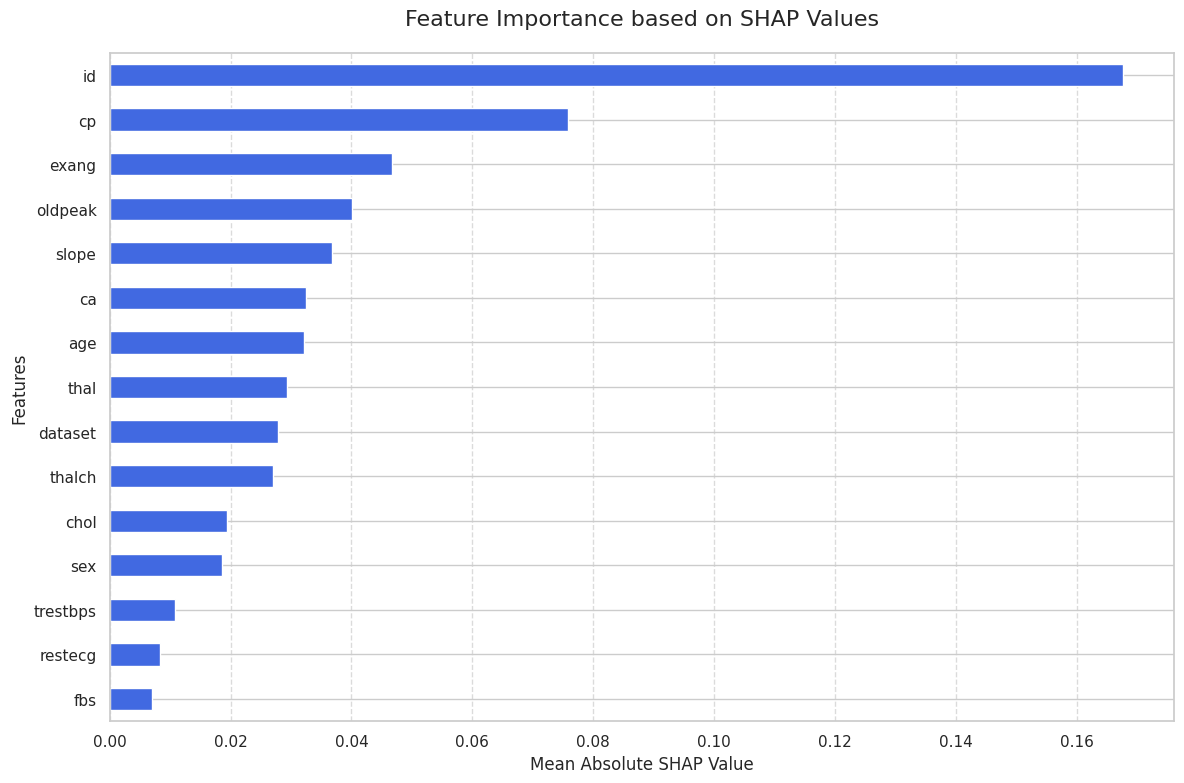

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay


plt.style.use('ggplot')
sns.set_theme(style="whitegrid")


if isinstance(shap_values, list):

    shap_values_array = np.array(shap_values[1])
else:
    shap_values_array = np.array(shap_values)


if shap_values_array.shape[1] != X_train.shape[1]:
    raise ValueError(f"Shape mismatch: SHAP values have {shap_values_array.shape[1]} features, X_train has {X_train.shape[1]}")


plt.figure(figsize=(12, 8))
feature_importance.sort_values().plot(kind='barh', color='royalblue')
plt.title('Feature Importance based on SHAP Values', fontsize=16, pad=20)
plt.xlabel('Mean Absolute SHAP Value', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



In [6]:
import pandas as pd
import numpy as np
import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline


df = pd.read_csv("/content/preprocessed_car_claim.csv")


y = df['OUTCOME'].apply(lambda x: 1 if x > 0 else 0)
X = df.drop(columns=['OUTCOME'])


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)


rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)


explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_train)


print("\nSHAP Values Structure Information:")
print(f"Type: {type(shap_values)}")
print(f"SHAP values shape: {shap_values.shape}")

mean_shap_values = np.abs(shap_values[:,:,1]).mean(axis=0)

mean_shap_values = mean_shap_values.flatten()


if len(mean_shap_values) != len(X_train.columns):
    print(f"\nDebug: Features ({len(X_train.columns)}): {X_train.columns.tolist()}")
    print(f"Debug: SHAP values shape: {mean_shap_values.shape}")
    if len(mean_shap_values) == 2 * len(X_train.columns):
        mean_shap_values = mean_shap_values[:len(X_train.columns)]
    else:
        raise ValueError(f"SHAP values dimension mismatch. Expected {len(X_train.columns)} features, got {len(mean_shap_values)} SHAP values")


shap_feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'SHAP_Importance': mean_shap_values
}).sort_values(by="SHAP_Importance", ascending=False)


selected_features = shap_feature_importance.head(12)['Feature'].tolist()
print("\nTop 7 Features Selected Based on SHAP Values:")
print(selected_features)


X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]


final_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(n_estimators=500, random_state=42))
])


final_pipeline.fit(X_train_selected, y_train)


y_pred_selected = final_pipeline.predict(X_test_selected)
y_proba_selected = final_pipeline.predict_proba(X_test_selected)[:, 1]


print("\nModel Performance with SHAP-selected Features (Top 7):")
print(f"Accuracy: {accuracy_score(y_test, y_pred_selected):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_proba_selected):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_selected))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_selected))


print("\nTop 7 Most Important Features Based on SHAP Values:")
print(shap_feature_importance.head(12)[['Feature', 'SHAP_Importance']].to_string(index=False))


SHAP Values Structure Information:
Type: <class 'numpy.ndarray'>
SHAP values shape: (7964, 18, 2)

Top 7 Features Selected Based on SHAP Values:
['DRIVING_EXPERIENCE', 'VEHICLE_OWNERSHIP', 'VEHICLE_YEAR', 'POSTAL_CODE', 'AGE', 'GENDER', 'SPEEDING_VIOLATIONS', 'PAST_ACCIDENTS', 'CREDIT_SCORE', 'MARRIED', 'ANNUAL_MILEAGE', 'ID']

Model Performance with SHAP-selected Features (Top 7):
Accuracy: 0.8393
ROC AUC: 0.9068

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.88      0.88      1369
           1       0.74      0.76      0.75       622

    accuracy                           0.84      1991
   macro avg       0.81      0.82      0.81      1991
weighted avg       0.84      0.84      0.84      1991


Confusion Matrix:
[[1201  168]
 [ 152  470]]

Top 7 Most Important Features Based on SHAP Values:
            Feature  SHAP_Importance
 DRIVING_EXPERIENCE         0.110218
  VEHICLE_OWNERSHIP         0.094455
       VEHICLE_YEAR 


SHAP Values Structure Information:
Type: <class 'numpy.ndarray'>
SHAP values shape: (7964, 18, 2)


<ipython-input-9-8807c53744ae>:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='SHAP_Importance', y='Feature', data=shap_feature_importance.head(12),


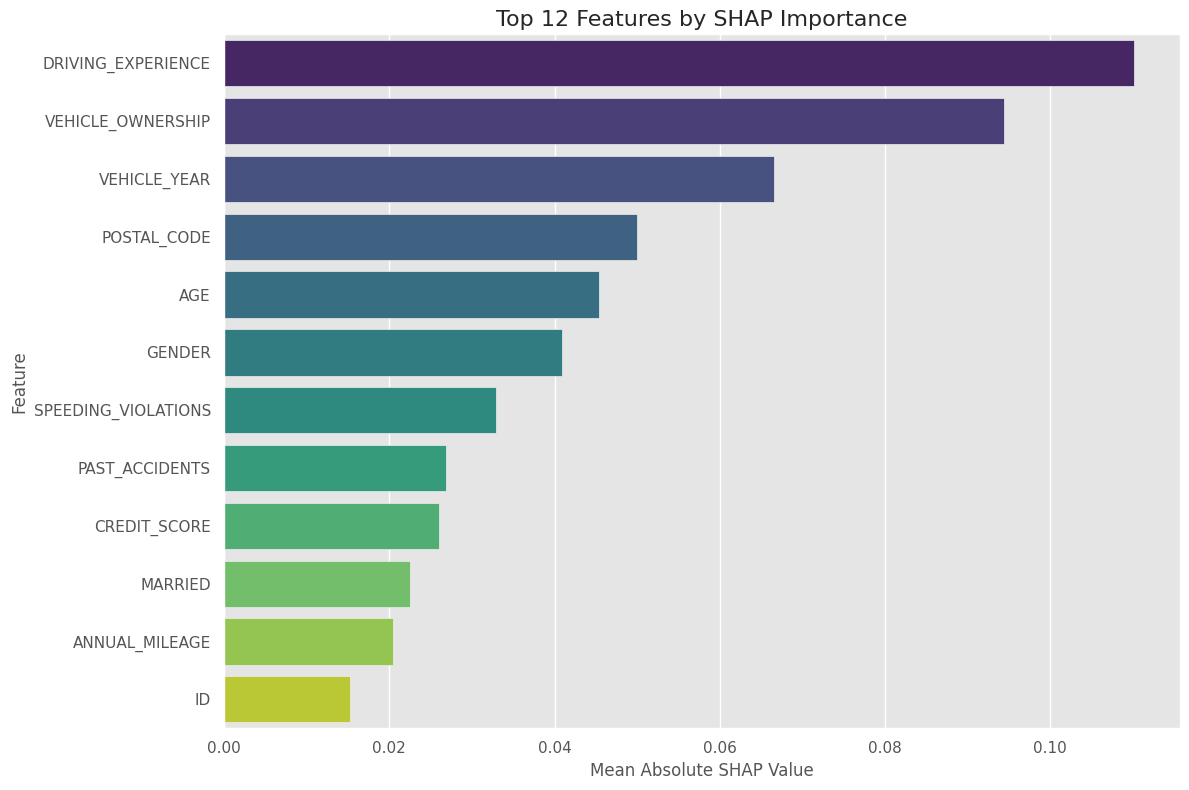

In [9]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, roc_auc_score, classification_report,
                            confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay)
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

plt.style.use('ggplot')
sns.set_palette("husl")


print("\nSHAP Values Structure Information:")
if isinstance(shap_values, list):
    print(f"Type: List of arrays (binary classification)")
    print(f"Class 0 shape: {shap_values[0].shape}")
    print(f"Class 1 shape: {shap_values[1].shape}")
else:
    print(f"Type: {type(shap_values)}")
    print(f"SHAP values shape: {shap_values.shape}")

if isinstance(shap_values, list):
    mean_shap_values = np.abs(shap_values[1]).mean(axis=0)
else:
    if len(shap_values.shape) == 3:
        mean_shap_values = np.abs(shap_values[:,:,1]).mean(axis=0)
    else:
        mean_shap_values = np.abs(shap_values).mean(axis=0)


if len(mean_shap_values) != len(X_train.columns):
    print(f"\nDebug: Features ({len(X_train.columns)}): {X_train.columns.tolist()}")
    print(f"Debug: SHAP values shape: {mean_shap_values.shape}")
    if len(mean_shap_values) == 2 * len(X_train.columns):
        mean_shap_values = mean_shap_values[:len(X_train.columns)]
    else:
        raise ValueError(f"SHAP values dimension mismatch. Expected {len(X_train.columns)} features, got {len(mean_shap_values)} SHAP values")


shap_feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'SHAP_Importance': mean_shap_values
}).sort_values(by="SHAP_Importance", ascending=False)


plt.figure(figsize=(12, 8))
sns.barplot(x='SHAP_Importance', y='Feature', data=shap_feature_importance.head(12),
            palette="viridis")
plt.title('Top 12 Features by SHAP Importance', fontsize=16)
plt.xlabel('Mean Absolute SHAP Value', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()
